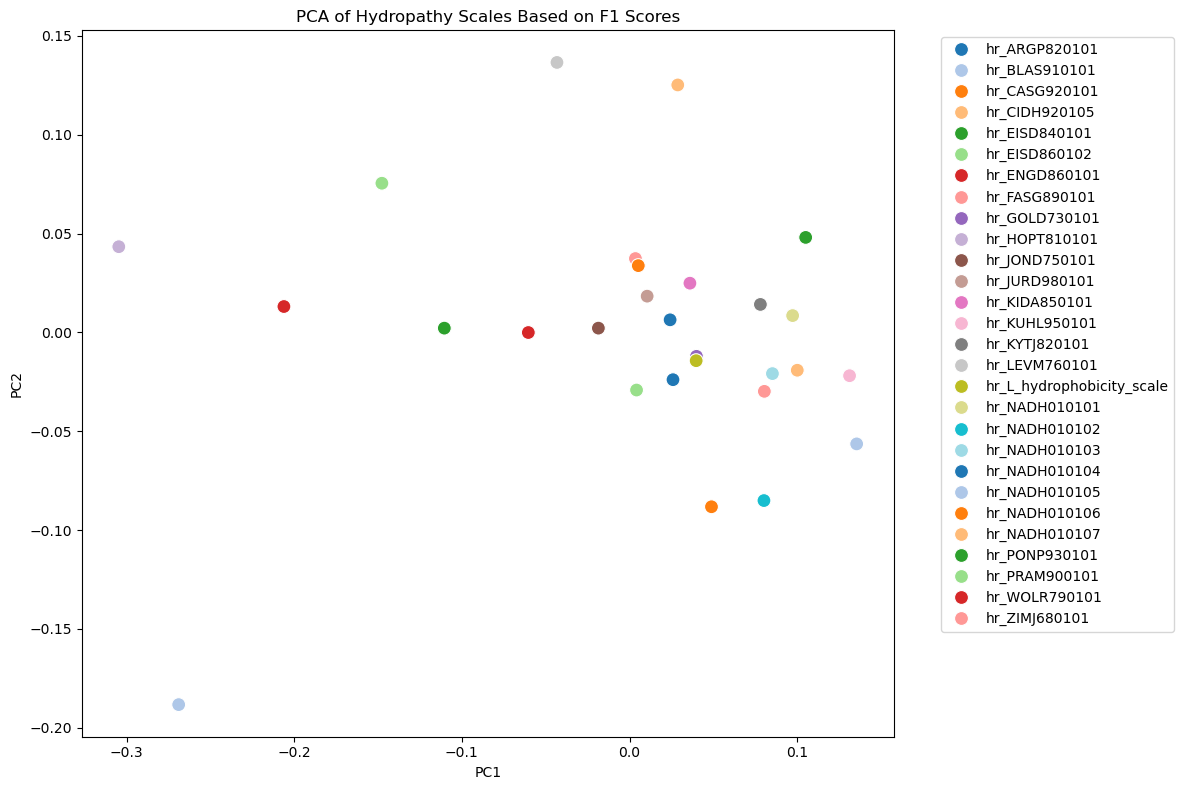

In [3]:
import os
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
project_root = r'C:\Jupyter Notebook\UOB labs\DSMP\Sapienza_data\progetto_bristol'
results_dir = os.path.join(project_root, 'results')
scales = [
    "hr_ARGP820101", "hr_BLAS910101", "hr_CASG920101", "hr_CIDH920105",
    "hr_EISD840101", "hr_EISD860102", "hr_ENGD860101", "hr_FASG890101",
    "hr_GOLD730101", "hr_HOPT810101", "hr_JOND750101", "hr_JURD980101",
    "hr_KIDA850101", "hr_KUHL950101", "hr_KYTJ820101", "hr_LEVM760101",
    "hr_NADH010101", "hr_NADH010102", "hr_NADH010103", "hr_NADH010104",
    "hr_NADH010105", "hr_NADH010106", "hr_NADH010107", "hr_PONP930101",
    "hr_PRAM900101", "hr_WOLR790101", "hr_ZIMJ680101", "hr_L_hydrophobicity_scale"
]

pairwise_data = []

for scale_name in scales:
    f1_csv_path = os.path.join(results_dir, f"{scale_name}.csv")
    if os.path.exists(f1_csv_path):
        df = pd.read_csv(f1_csv_path)
        df["Scale"] = scale_name
        pairwise_data.append(df)
    else:
        print(f" Missing F1 CSV: {scale_name}.csv")

# Only proceed if we have data
if not pairwise_data:
    raise ValueError(" No F1 CSV files found. Please re-run your automation script.")

# Step 2: Combine and pivot
pairwise_df = pd.concat(pairwise_data, ignore_index=True)
pivot_df = pairwise_df.pivot(index='Scale', columns='residue_pair', values='F1-score').fillna(0)

# Step 3: PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivot_df)
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Scale"] = pivot_df.index

# Step 4: Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Scale", palette="tab20", s=100)
plt.title("PCA of Hydropathy Scales Based on F1 Scores")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "pca_hydropathy_scales.png"))
plt.show()


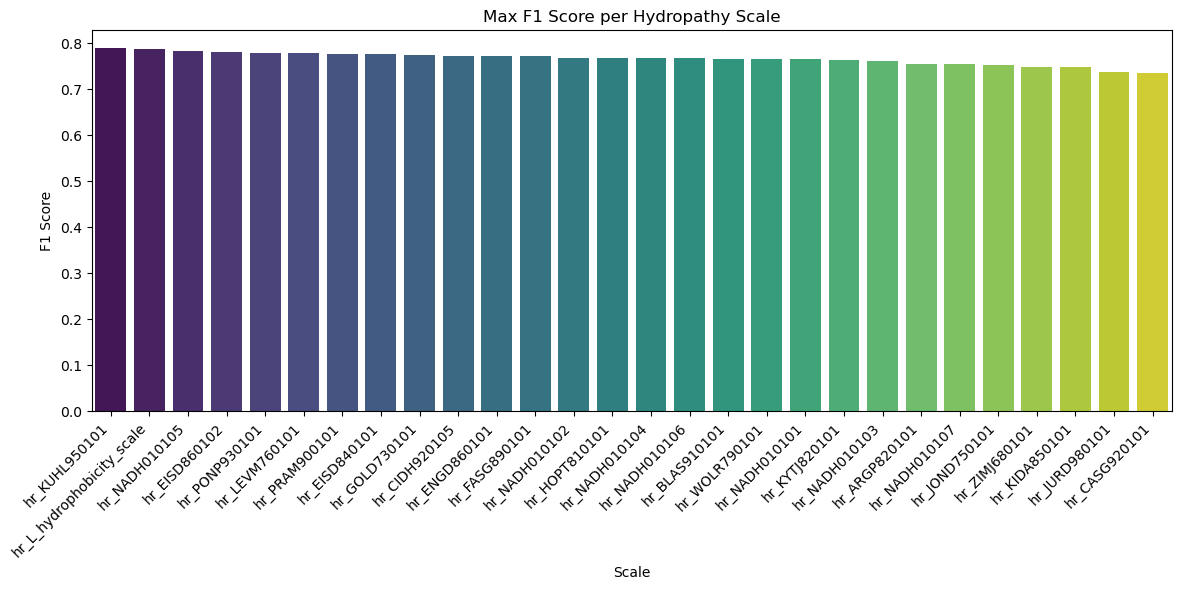

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=metrics_df.sort_values("F1_Score", ascending=False),
    x="Scale",
    y="F1_Score",
    hue="Scale",             # Add hue to apply palette
    palette="viridis",
    dodge=False,             # Prevent bars from separating
    legend=False             # Optional: avoid crowded legends
)
plt.xticks(rotation=45, ha="right")
plt.title("Max F1 Score per Hydropathy Scale")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "f1_score_per_scale.png"))
plt.show()
plt.close()


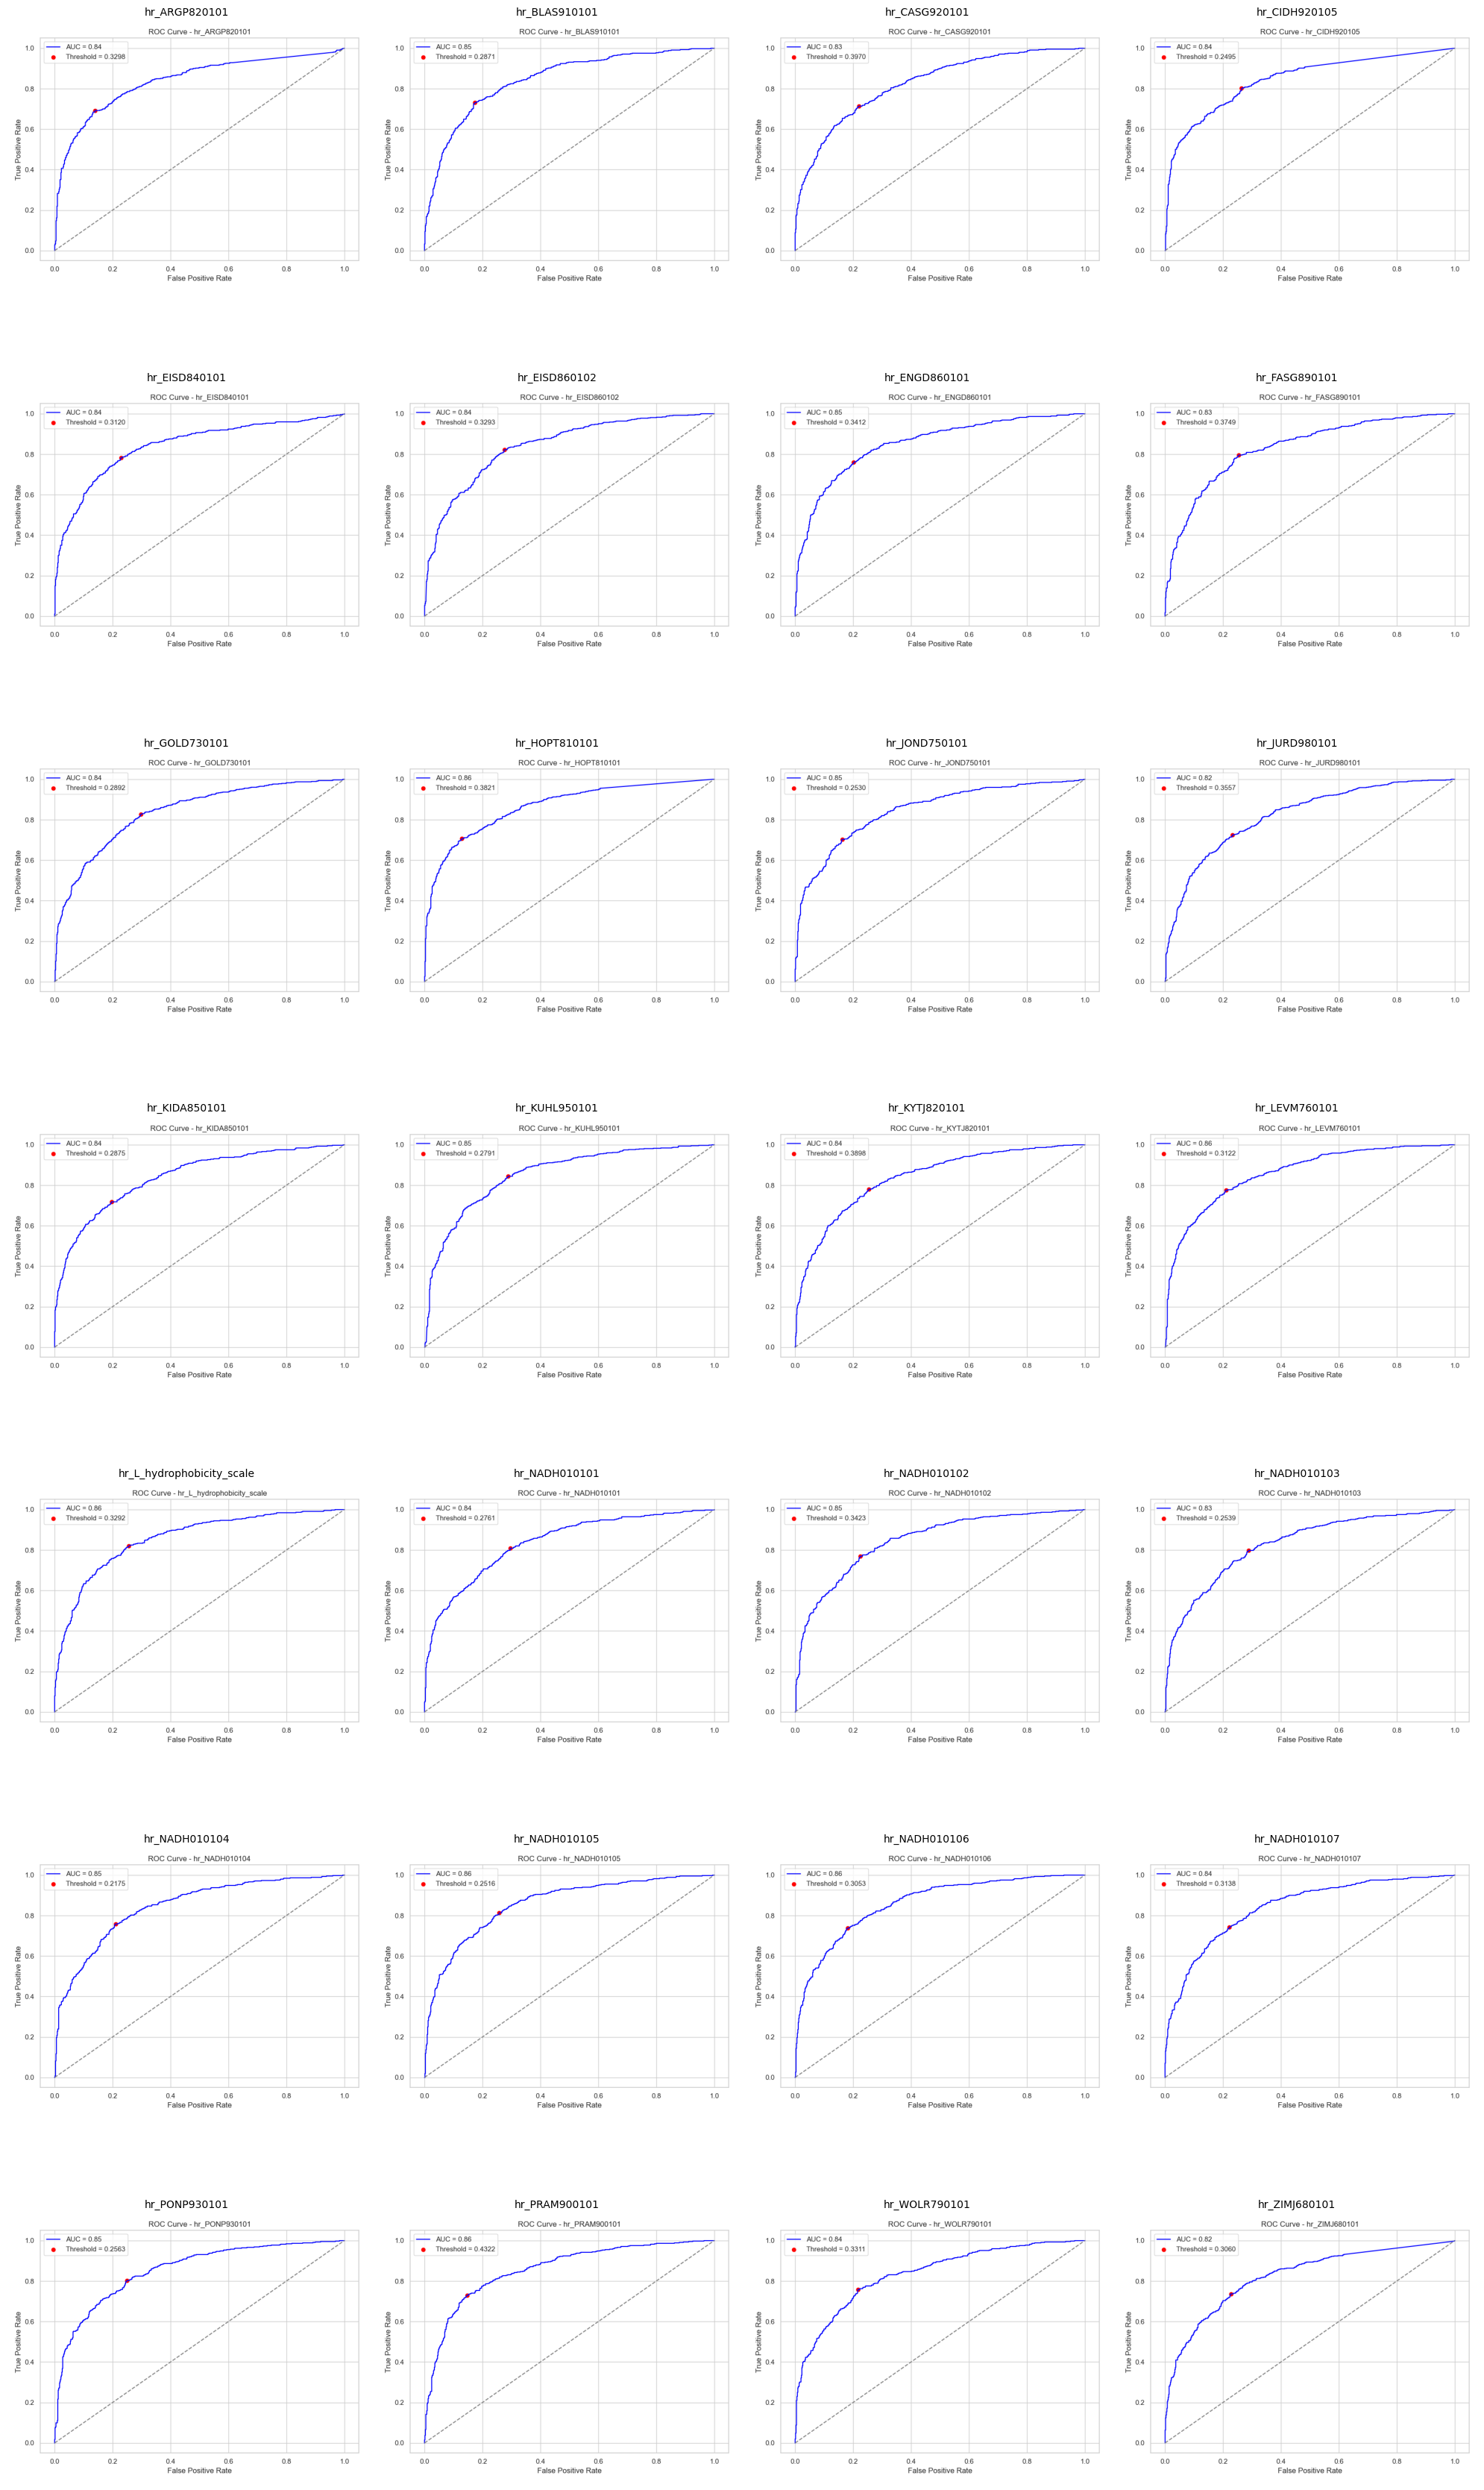

In [39]:
from glob import glob
import matplotlib.image as mpimg

roc_images = sorted(glob(os.path.join(results_dir, "*_roc.png")))
n = len(roc_images)
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, img_path in enumerate(roc_images):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(os.path.basename(img_path).replace("_roc.png", ""), fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "all_roc_curves_grid.png"))
plt.show()
plt.close()


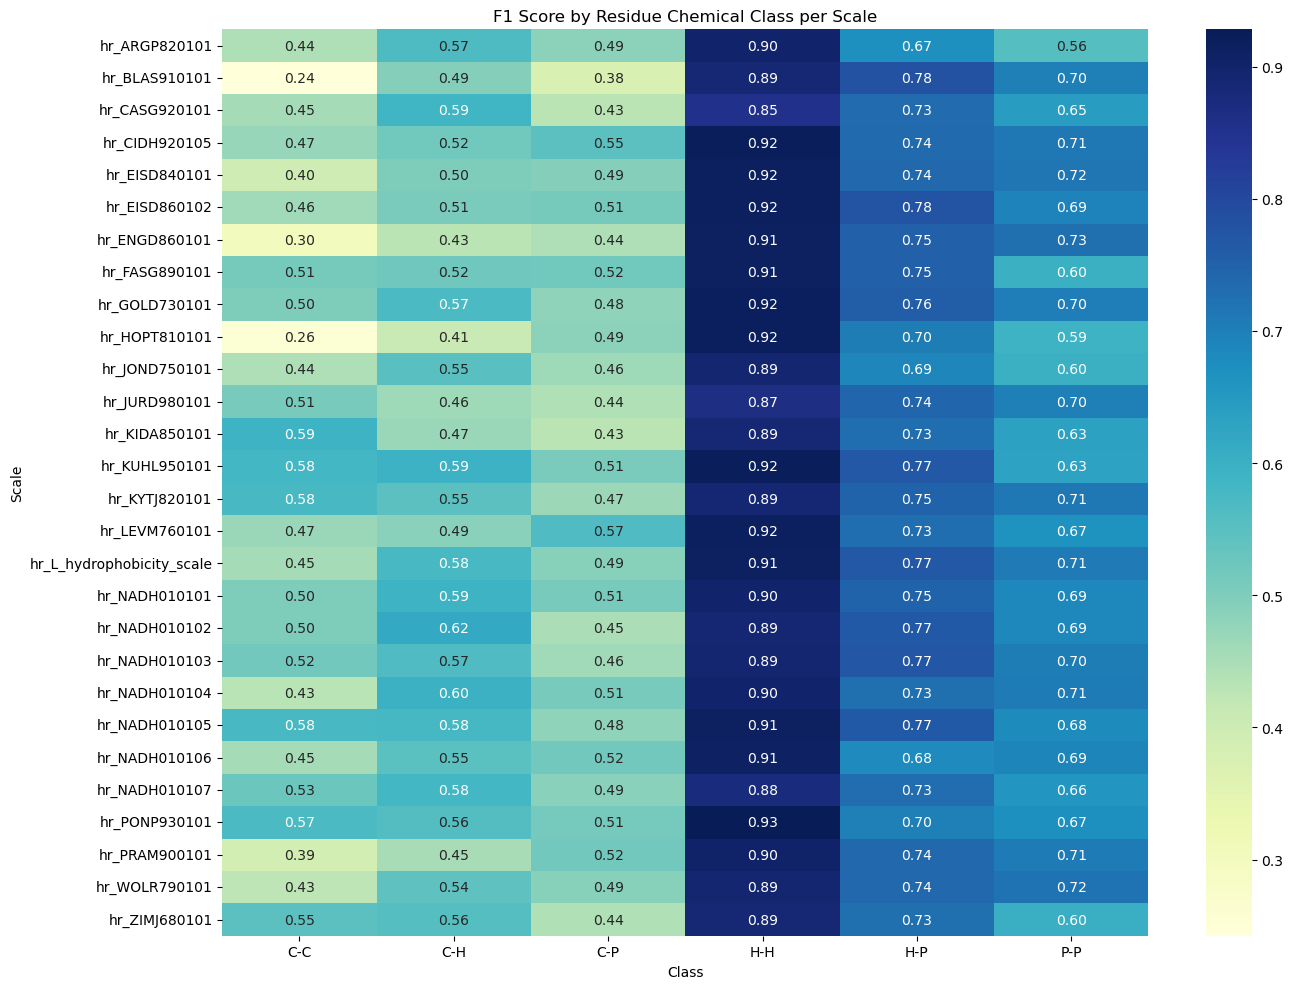

In [41]:
# For each scale, calculate average F1 per residue class pair
chemical_class_scores = []

for scale in scales:
    path = os.path.join(results_dir, f"{scale}.csv")
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    df["Class"] = df["residue_pair"].apply(lambda x: "-".join(sorted(x.split("-"))))  # Normalize order
    df["Scale"] = scale
    grouped = df.groupby("Class")["F1-score"].mean().reset_index()
    grouped["Scale"] = scale
    chemical_class_scores.append(grouped)

chem_df = pd.concat(chemical_class_scores)
chem_pivot = chem_df.pivot(index="Scale", columns="Class", values="F1-score").fillna(0)

# Heatmap of F1 per class
plt.figure(figsize=(14, 10))
sns.heatmap(chem_pivot, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("F1 Score by Residue Chemical Class per Scale")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "f1_by_chemical_class_heatmap.png"))
plt.show()
plt.close()


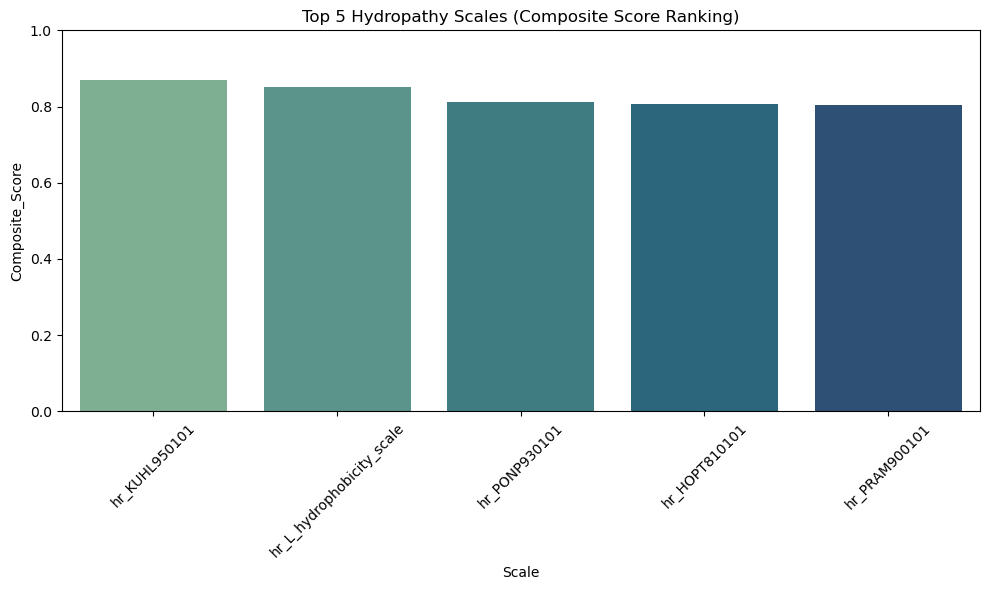

In [49]:
# Paths
project_root = r'C:\Jupyter Notebook\UOB labs\DSMP\Sapienza_data\progetto_bristol'
results_dir = os.path.join(project_root, 'results')

# Load global metrics
metrics_df = pd.read_csv(os.path.join(results_dir, 'hydropathy_scale_metrics.csv'))

# Get max per-class F1 from each scale's CSV
max_f1_per_class = []
for scale in metrics_df['Scale']:
    scale_csv = os.path.join(results_dir, f"{scale}.csv")
    if os.path.exists(scale_csv):
        df = pd.read_csv(scale_csv)
        max_f1 = df["F1-score"].max()
        max_f1_per_class.append(max_f1)
    else:
        max_f1_per_class.append(None)

metrics_df["Max_Class_F1"] = max_f1_per_class

# Drop any missing entries (in case some scales didn’t generate F1 CSVs)
metrics_df.dropna(inplace=True)

# Normalize scores
for col in ["Accuracy", "F1_Score", "Optimal_Threshold", "Max_Class_F1"]:
    min_val = metrics_df[col].min()
    max_val = metrics_df[col].max()
    metrics_df[f"{col}_norm"] = (metrics_df[col] - min_val) / (max_val - min_val)

# Composite Score (you can adjust weights if needed)
metrics_df["Composite_Score"] = metrics_df[[
    "Accuracy_norm", "F1_Score_norm", "Max_Class_F1_norm"
]].mean(axis=1)

# Rank and sort
ranked_df = metrics_df.sort_values("Composite_Score", ascending=False).reset_index(drop=True)

# Save to CSV
ranked_df.to_csv(os.path.join(results_dir, "ranked_hydropathy_scales.csv"), index=False)

# Plot top 5
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ranked_df.head(5),
    x="Scale",
    y="Composite_Score",
    hue="Scale",        # Use Scale as hue to apply the palette
    palette="crest",
    dodge=False,
    legend=False        # Hide legend since x already labels the bars
)
plt.title("Top 5 Hydropathy Scales (Composite Score Ranking)")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "top5_composite_scores.png"))
plt.show()
plt.close()